In [27]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split


In [28]:
df_original = pd.read_csv("./data_cleaned.csv")
df_original.head()
df_original.drop (['avg_price_year_type'], inplace=True, axis=1)

In [29]:
years = df_original['year'].unique()

In [30]:
def random_forest(X_train, X_test, y_train, y_test):
    param_dist = {
    'n_estimators': [100,1000,1500],
    }

    rf = RandomForestRegressor()

    grid_search_rf = GridSearchCV(rf, param_dist, cv=5)

    grid_search_rf.fit(X_train, y_train)
    prediction = grid_search_rf.predict(X_test)
    mse = mean_squared_error(y_test, prediction)
    rmse = mse**.5
    return rmse, grid_search_rf.best_params_

In [31]:
def gradient_booster(X_train, X_test, y_train, y_test):
    model = GradientBoostingRegressor(random_state=42)

    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.0001, 0.001],
        'max_depth': [3, 5, 7, 9, 11]
    }

    grid_search_gb = GridSearchCV(model, param_grid, cv=5)
    grid_search_gb.fit(X_train, y_train)

    y_pred = grid_search_gb.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse, grid_search_gb.best_params_

In [32]:
def mlp(X_train, X_test, y_train, y_test):
    param_dist = {
    'hidden_layer_sizes': [(60,40, 1), (60,120,60,1), (60, 30, 1)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.5],
    'learning_rate': ['constant','adaptive'],
    }

    mlp = MLPRegressor()

    rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

    grid_search_mlp = GridSearchCV(mlp, param_dist, cv=5, scoring=rmse_scorer, n_jobs=-1)

    grid_search_mlp.fit(X_train, y_train)

    y_pred = grid_search_mlp.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse, grid_search_mlp.best_params_

In [33]:
def convert_data(data): 
    df_converted = data.copy()
    categorical = ['location']
    numeric = ['garage', 'balcony', 'roof', 'garden', 'bedrooms']

    for cat in categorical:
        dummies = pd.get_dummies(df_converted[cat], prefix=cat)
        df_converted = pd.concat([df_converted, dummies], axis=1)
        df_converted.drop(cat, axis=1, inplace=True)

    mm_scaler = MinMaxScaler()
    for num in numeric:
        df_converted[num] = mm_scaler.fit_transform(df_converted[[num]])

    return df_converted

In [34]:
def get_results(year, threshold):
    results = []
    df = df_original.query('year=={}'.format(year)).copy()
    types = df['type'].value_counts()
    for value, count in types.items():
        if (count>threshold):
            df_temp = df.query('type == "{}"'.format(value))
            df_converted = convert_data(df_temp)
            X = df_converted.copy()
            X.drop(['price', 'type'], inplace=True, axis=1)
            y = df_converted['price']
            X_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=123)
            rmse, best_params = random_forest(X_train, x_test, y_train, y_test)
            results.append({"year": year, "type": value, "rmse" : rmse, "algorithm":"random-forest", "best_params" : best_params})
            rmse, best_params = gradient_booster(X_train, x_test, y_train, y_test)
            results.append({"year": year, "type": value, "rmse" : rmse, "algorithm":"gb", "best_params" : best_params})
            rmse, best_params = mlp(X_train, x_test, y_train, y_test)
            results.append({"year": year, "type": value, "rmse" : rmse, "algorithm":"mlp", "best_params" : best_params})
    return results

In [35]:
results = []
for year in years:
    x = get_results(year, 50)
    for item in x:
        results.append(item)

KeyboardInterrupt: 

In [ ]:
x = pd.DataFrame(results)
x.to_csv('./results_combinations.csv', index=None)

In [ ]:
visual_df = pd.read_csv('results_combinations.csv')

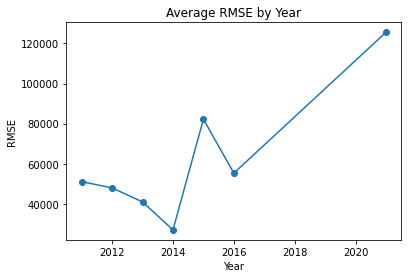

In [31]:
# Group the data by year and calculate the average RMSE
grouped_df = visual_df.groupby('year')['rmse'].mean().reset_index()

# Plot the chart
plt.plot(grouped_df['year'], grouped_df['rmse'], marker='o')

# Customize the chart
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.title('Average RMSE by Year')

# Display the chart
plt.show()

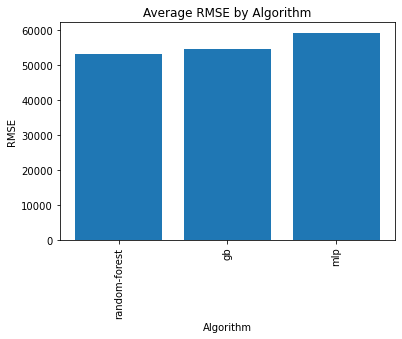

In [48]:
# Group the data by algorithm and calculate the average RMSE
grouped_df = visual_df.groupby('algorithm')['rmse'].mean().reset_index()

# Sort the data by RMSE values in ascending order
sorted_df = grouped_df.sort_values('rmse')

# Plot the chart
plt.bar(sorted_df['algorithm'], sorted_df['rmse'])

# Customize the chart
plt.xlabel('Algorithm')
plt.ylabel('RMSE')
plt.title('Average RMSE by Algorithm')
plt.xticks(rotation=90)

# Display the chart
plt.show()

/var/folders/6c/7v93vfjd6xzbjd_9t7b6x6p80000gn/T/ipykernel_6203/2415585233.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([textwrap.fill(label, 15) for label in sorted_df['best_params']])


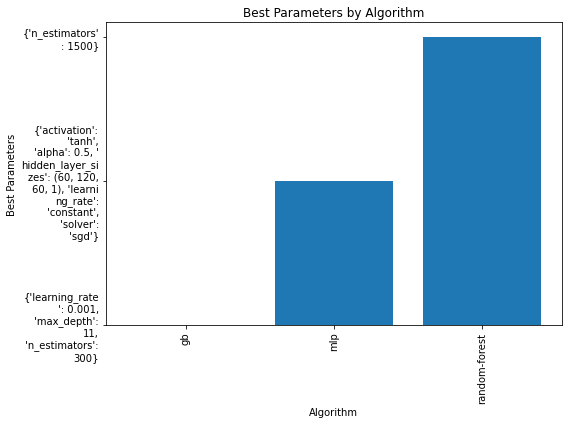

In [18]:
import textwrap  # Import the textwrap module

# Group the data by algorithm and extract the best parameters
grouped_df = visual_df.groupby('algorithm')['best_params'].first().reset_index()

# Sort the data alphabetically by algorithm name
sorted_df = grouped_df.sort_values('algorithm')

# Plot the chart
plt.figure(figsize=(8, 6))  # Adjust the figure size as per your preference
plt.bar(sorted_df['algorithm'], sorted_df['best_params'])

# Customize the chart
plt.xlabel('Algorithm')
plt.ylabel('Best Parameters')
plt.title('Best Parameters by Algorithm')
plt.xticks(rotation=90)

# Manually adjust tick labels with line breaks
plt.gca().set_yticklabels([textwrap.fill(label, 15) for label in sorted_df['best_params']])

# Display the chart
plt.tight_layout()  # Ensures the labels fit within the figure boundaries
plt.show()

In [1]:
# Group the data by algorithm and extract the best parameters
grouped_df = visual_df.groupby('best_params')['rmse'].first().reset_index()

# Sort the data alphabetically by algorithm name
sorted_df = grouped_df.sort_values('rmse')

# Plot the chart
plt.bar(sorted_df['best_params'], sorted_df['rmse'])

# Customize the chart
plt.xlabel('Best Parameters')
plt.ylabel('RMSE')
plt.title('Best Parameters by rmse')
plt.xticks(rotation=90)

# Display the chart
plt.show()

NameError: name 'visual_df' is not defined